In [1]:
"""
═══════════════════════════════════════════════════════════════════════════
Bochra LAFIFI, IASD 2025
COURSE PROJECT: ZEROTH-ORDER OPTIMIZATION ON MNIST

═══════════════════════════════════════════════════════════════════════════
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from time import time
import warnings

# Set random seed for reproducibility
np.random.seed(42)



## Data Preparation

  Training samples: 2400
  Test samples: 600
  Feature dimension d: 784
  Class balance: 0 negative, 1167 positive


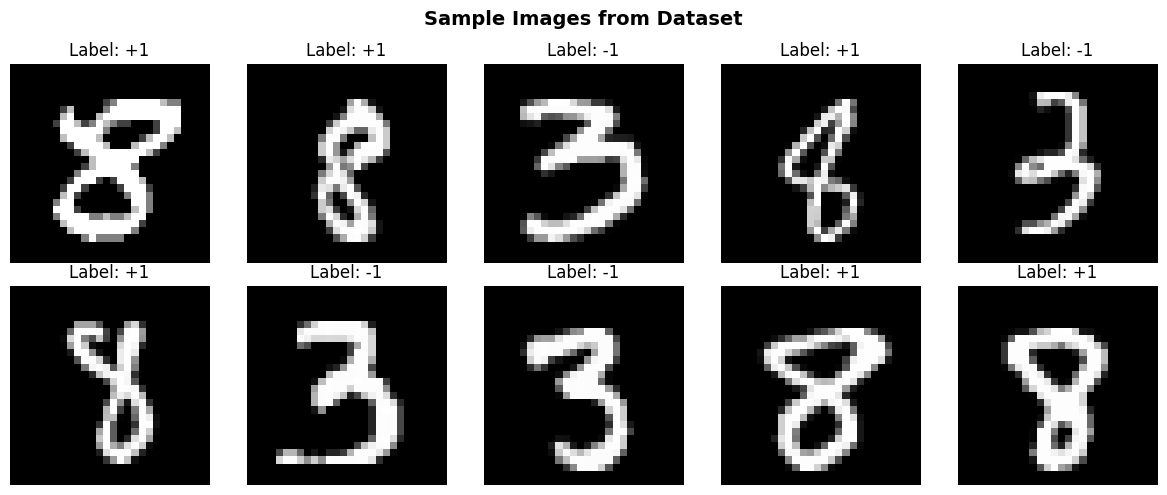

In [2]:
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data, mnist.target.astype(int)

# Convert to numpy arrays
if hasattr(X, 'values'):
    X = X.values
if hasattr(y, 'values'):
    y = y.values

# Selected 3 and 8 for ex
c1, c2 = 3, 8
mask = (y == c1) | (y == c2)
X_binary = X[mask]
y_binary = y[mask]

y_binary = np.where(y_binary == c1, 0, 1)

# Normalize features to [0, 1]
X_binary = X_binary / 255.0

# Take subset for faster computation
n_samples = 3000
if n_samples < len(X_binary):
    indices = np.random.choice(len(X_binary), n_samples, replace=False)
    X_binary = X_binary[indices]
    y_binary = y_binary[indices]

X_train, X_test, y_train, y_test = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)


print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Feature dimension d: {X_train.shape[1]}")
print(f"  Class balance: {np.sum(y_train == -1)} negative, {np.sum(y_train == 1)} positive")

# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for idx in range(10):
    ax = axes[idx // 5, idx % 5]
    ax.imshow(X_train[idx].reshape(28, 28), cmap='gray')
    label = '+1' if y_train[idx] == 1 else '-1'
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.suptitle('Sample Images from Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [3]:
class AutogradFunction:
    def __init__(self, X, y):
        """
        Parameters:
        -----------
        X : array (n, d) - feature matrix
        y : array (n,) - labels in {-1, +1}
        """
        self.X = X
        self.y = y
        self.n, self.d = X.shape

    def sigmoid(self, t):
        return np.where(
            t >= 0,
            1 / (1 + np.exp(-t)),
            np.exp(t) / (1 + np.exp(t))
        )

    def f_i(self, w, i):
        """
        Loss for single sample i: f_i(w) = (y_i - sigma(x_i^T w))^2
        """
        z = np.dot(self.X[i], w)
        pred = self.sigmoid(z)
        return (self.y[i] - pred) ** 2

    def f(self, w):
        """
        Total loss: f(w) = (1/n) * sum_i f_i(w)
        """
        z = np.dot(self.X, w)
        pred = self.sigmoid(z)
        return np.mean((self.y - pred) ** 2)

    def f_i_autograd(self, w, i):
    # Convert w to Node objects
        w_nodes = [Node(val=w[j]) for j in range(self.d)]
        x = self.X[i]

        # Compute z = x_i^T w
        z = None
        for j in range(self.d):
            term = w_nodes[j] * x[j]
            z = term if z is None else z + term

        # sigmoid(z) = 1 / (1 + exp(-z))
        sig = 1 / (1 + (-z).exp())

        # f_i(w) = (y_i - sig)^2
        loss = (self.y[i] - sig)**2

        return loss, w_nodes

    def grad_f_i_autograd(self, w, i):
        loss, w_nodes = self.f_i_autograd(w, i)

        # Reset gradients (if your framework requires)
        for node in w_nodes:
            node.grad = 0

        # Run backward pass
        loss.backward()

        # Extract gradient for each w_j
        grad = np.array([node.grad for node in w_nodes])
        return grad

    def grad_f_i_analytical(self, w, i):
        z = np.dot(self.X[i], w)
        sig = self.sigmoid(z)

        coeff = 2 * (sig - self.y[i]) * sig * (1 - sig)
        return coeff * self.X[i]


    def grad_f_analytical(self, w):
        """
        Full gradient: ∇f(w) = (1/n) * sum_i ∇f_i(w)
        """
        grad = np.zeros(self.d)
        for i in range(self.n):
            grad += self.grad_f_i_analytical(w, i)
        return grad / self.n

In [4]:
# Create function object
func_obj = AutogradFunction(X_train, y_train)
d = X_train.shape[1]
w0 = np.zeros(d)

print(f"\n Initial loss f(0): {func_obj.f(w0):.6f}")



 Initial loss f(0): 0.250000


## Question 1 - Validate Gradient Implementation

In [5]:
# Create small test problem for validation
n_val, d_val = 10, 5
X_val = np.random.randn(n_val, d_val)
y_val = np.random.choice([0, 1], size=n_val)
func_val = AutogradFunction(X_val, y_val)
w_test = np.random.randn(d_val)

# Compute analytical gradient for sample i=0
i = 0
grad_analytical = func_val.grad_f_i_analytical(w_test, i)

# Compute numerical gradient using finite differences
eps = 1e-5
grad_numerical = np.zeros(d_val)
f0 = func_val.f_i(w_test, i)
for j in range(d_val):
    w_perturbed = w_test.copy()
    w_perturbed[j] += eps
    grad_numerical[j] = (func_val.f_i(w_perturbed, i) - f0) / eps

# Compare gradients
diff = np.linalg.norm(grad_analytical - grad_numerical)
rel_diff = diff / (np.linalg.norm(grad_analytical) + 1e-10)

print(f"\nGradient validation for f_{i}(w):")
print(f"  Analytical gradient: {grad_analytical[:3]} (first 3 components)")
print(f"  Numerical gradient:  {grad_numerical[:3]} (first 3 components)")
print(f"  Absolute difference: {diff:.2e}")
print(f"  Relative difference: {rel_diff:.2e}")

if rel_diff < 1e-4:
    print("\nGradient implementation validated!")
    print("  Analytical and numerical gradients match to high precision.")
else:
    print("\nLarge difference detected. re-Check")



Gradient validation for f_0(w):
  Analytical gradient: [ 0.00475602 -0.00635415 -0.00430906] (first 3 components)
  Numerical gradient:  [ 0.00475606 -0.00635408 -0.00430903] (first 3 components)
  Absolute difference: 8.10e-08
  Relative difference: 8.38e-06

Gradient implementation validated!
  Analytical and numerical gradients match to high precision.


## Question 2: Standard Gradient Descent with exact gradients


In [6]:
class GradientDescent:

    def __init__(self, func_obj):
        self.func_obj = func_obj
        self.n = func_obj.n
        self.d = func_obj.d
        self.history = {'loss': [], 'time': [], 'iterations': [],
                       'grad_norm': [], 'func_evals': []}

    def optimize(self, w0, max_iter=300, step_size=0.01, verbose=False, eval_freq=10):
        w = w0.copy()
        start_time = time()
        func_evals = 0

        for k in range(max_iter):
            grad = self.func_obj.grad_f_analytical(w)
            func_evals += self.n
            w = w - step_size * grad

            if k % eval_freq == 0:
                loss = self.func_obj.f(w)
                func_evals += self.n
                elapsed = time() - start_time

                self.history['loss'].append(loss)
                self.history['time'].append(elapsed)
                self.history['iterations'].append(k)
                self.history['grad_norm'].append(np.linalg.norm(grad))
                self.history['func_evals'].append(func_evals)

                if verbose and k % (eval_freq * 10) == 0:
                    print(f"  Iter {k:4d} | Loss: {loss:.6f} | ||∇f||: {np.linalg.norm(grad):.4f}")

        return w



Expected convergence rate: O(1/k) for smooth non-convex problems

Testing different step sizes:

  Testing α = 0.01...
    Final loss: 0.093799

  Testing α = 0.05...
    Final loss: 0.050410

  Testing α = 0.1...
    Final loss: 0.040194

  Testing α = 0.5...
    Final loss: 0.026106

 Best step size: α = 0.5
  Final loss: 0.026106


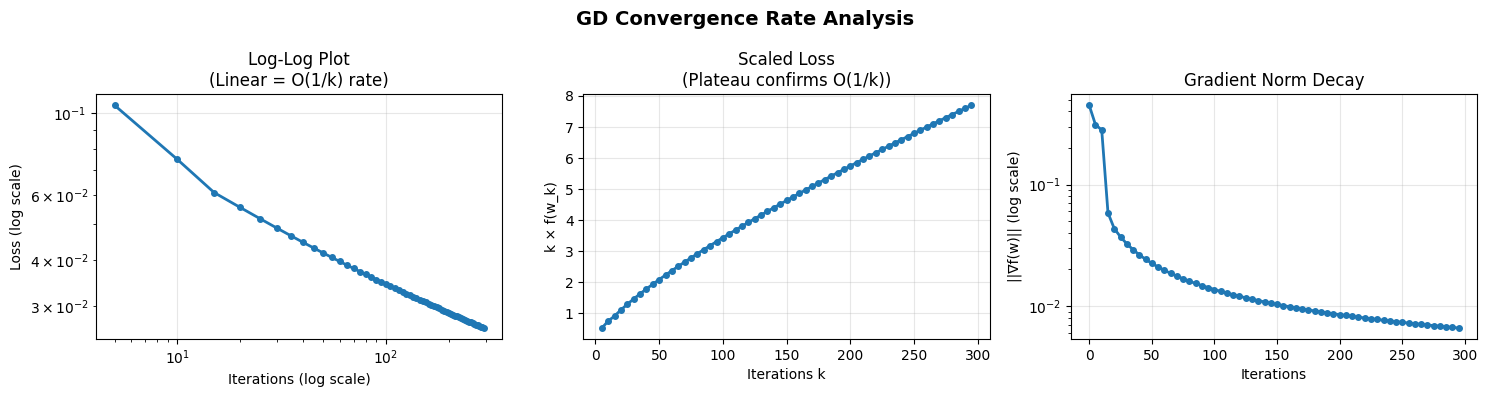

In [7]:
print("\nExpected convergence rate: O(1/k) for smooth non-convex problems")

# Test different step sizes
print("\nTesting different step sizes:")
step_sizes_gd = [0.01, 0.05, 0.1, 0.5]
gd_results = []

for alpha in step_sizes_gd:
    print(f"\n  Testing α = {alpha}...")
    gd = GradientDescent(func_obj)
    w_gd = gd.optimize(w0.copy(), max_iter=300, step_size=alpha,
                       verbose=False, eval_freq=5)
    final_loss = gd.history['loss'][-1]
    print(f"    Final loss: {final_loss:.6f}")
    gd_results.append((alpha, gd))

# Select best
best_alpha_gd = min(gd_results, key=lambda x: x[1].history['loss'][-1])[0]
best_gd = [gd for alpha, gd in gd_results if alpha == best_alpha_gd][0]

print(f"\n Best step size: α = {best_alpha_gd}")
print(f"  Final loss: {best_gd.history['loss'][-1]:.6f}")

# Convergence rate analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

iterations = np.array(best_gd.history['iterations'])
losses = np.array(best_gd.history['loss'])

# Plot 1: Log-log (O(1/k) appears linear)
axes[0].loglog(iterations[1:], losses[1:], 'o-', markersize=4, linewidth=2)
axes[0].set_xlabel('Iterations (log scale)')
axes[0].set_ylabel('Loss (log scale)')
axes[0].set_title('Log-Log Plot\n(Linear = O(1/k) rate)')
axes[0].grid(True, alpha=0.3)

# Plot 2: k * f(w_k) should plateau for O(1/k)
axes[1].plot(iterations[1:], iterations[1:] * losses[1:], 'o-', markersize=4, linewidth=2)
axes[1].set_xlabel('Iterations k')
axes[1].set_ylabel('k × f(w_k)')
axes[1].set_title('Scaled Loss\n(Plateau confirms O(1/k))')
axes[1].grid(True, alpha=0.3)

# Plot 3: Gradient norm
axes[2].semilogy(iterations, best_gd.history['grad_norm'], 'o-', markersize=4, linewidth=2)
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('||∇f(w)|| (log scale)')
axes[2].set_title('Gradient Norm Decay')
axes[2].grid(True, alpha=0.3)

plt.suptitle('GD Convergence Rate Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


**Empirical observation:** The plateau in k×f(w_k) confirms O(1/k) rate


## Question 3: SGD with mini-batches


In [8]:
class StochasticGradientDescent:
    def __init__(self, func_obj):
        self.func_obj = func_obj
        self.n = func_obj.n
        self.d = func_obj.d
        self.history = {'loss': [], 'time': [], 'iterations': [],
                       'grad_norm': [], 'func_evals': []}

    def optimize(self, w0, max_iter=300, step_size=0.5, batch_size=32,
                 step_schedule='decay', verbose=False, eval_freq=10):
        w = w0.copy()
        start_time = time()
        func_evals = 0

        for k in range(max_iter):
            batch_indices = np.random.choice(self.n, size=batch_size, replace=False)
            grad_batch = np.zeros(self.d)
            for i in batch_indices:
                grad_batch += self.func_obj.grad_f_i_analytical(w, i)
            grad_batch /= batch_size
            func_evals += batch_size

            if step_schedule == 'decay':
                alpha_k = step_size / (1 + 0.01 * k)
            else:
                alpha_k = step_size

            w = w - alpha_k * grad_batch

            if k % eval_freq == 0:
                loss = self.func_obj.f(w)
                func_evals += self.n
                elapsed = time() - start_time

                self.history['loss'].append(loss)
                self.history['time'].append(elapsed)
                self.history['iterations'].append(k)
                self.history['grad_norm'].append(np.linalg.norm(grad_batch))
                self.history['func_evals'].append(func_evals)

                if verbose and k % (eval_freq * 10) == 0:
                    print(f"  Iter {k:4d} | Loss: {loss:.6f}")

        return w


i) Testing different batch sizes (with decay schedule):
  Testing batch_size = 16...
    Final loss: 0.031835
  Testing batch_size = 32...
    Final loss: 0.031967
  Testing batch_size = 64...
    Final loss: 0.032078
  Testing batch_size = 128...
    Final loss: 0.031628
  Testing batch_size = 256...
    Final loss: 0.031756

Best batch size: 128

ii) Testing step sizes for batch_size = 128:
  α = 0.1: Final loss = 0.051641
  α = 0.3: Final loss = 0.036421
  α = 0.5: Final loss = 0.031575
  α = 1.0: Final loss = 0.026674

Best step size: α = 1.0
  Final loss: 0.026674


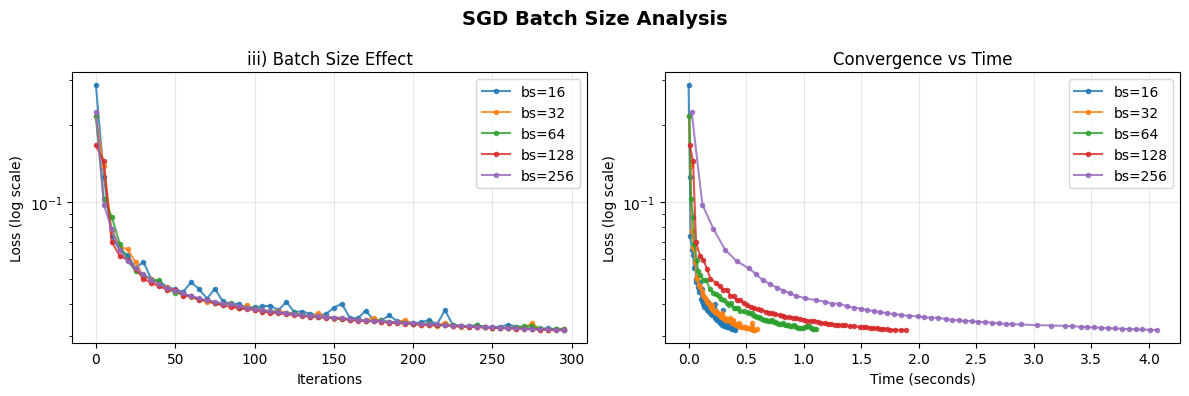

In [9]:
# i) Test different batch sizes
print("\ni) Testing different batch sizes (with decay schedule):")
batch_sizes = [16, 32, 64, 128, 256]
sgd_results = []

for bs in batch_sizes:
    print(f"  Testing batch_size = {bs}...")
    sgd = StochasticGradientDescent(func_obj)
    w_sgd = sgd.optimize(w0.copy(), max_iter=300, step_size=0.5,
                         batch_size=bs, step_schedule='decay',
                         verbose=False, eval_freq=5)
    final_loss = sgd.history['loss'][-1]
    print(f"    Final loss: {final_loss:.6f}")
    sgd_results.append((bs, sgd))

best_bs = min(sgd_results, key=lambda x: x[1].history['loss'][-1])[0]
print(f"\nBest batch size: {best_bs}")

# ii) Test step sizes for best batch size
print(f"\nii) Testing step sizes for batch_size = {best_bs}:")
step_sizes_sgd = [0.1, 0.3, 0.5, 1.0]
sgd_step_results = []

for alpha in step_sizes_sgd:
    sgd = StochasticGradientDescent(func_obj)
    w_sgd = sgd.optimize(w0.copy(), max_iter=300, step_size=alpha,
                         batch_size=best_bs, step_schedule='decay',
                         verbose=False, eval_freq=5)
    final_loss = sgd.history['loss'][-1]
    print(f"  α = {alpha}: Final loss = {final_loss:.6f}")
    sgd_step_results.append((alpha, sgd))

best_alpha_sgd = min(sgd_step_results, key=lambda x: x[1].history['loss'][-1])[0]
best_sgd = [sgd for alpha, sgd in sgd_step_results if alpha == best_alpha_sgd][0]

print(f"\nBest step size: α = {best_alpha_sgd}")
print(f"  Final loss: {best_sgd.history['loss'][-1]:.6f}")

# Plot batch size comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for bs, sgd in sgd_results:
    axes[0].semilogy(sgd.history['iterations'], sgd.history['loss'],
                     'o-', markersize=3, label=f'bs={bs}', alpha=0.8)
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Loss (log scale)')
axes[0].set_title('iii) Batch Size Effect')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for bs, sgd in sgd_results:
    axes[1].semilogy(sgd.history['time'], sgd.history['loss'],
                     'o-', markersize=3, label=f'bs={bs}', alpha=0.8)
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Loss (log scale)')
axes[1].set_title('Convergence vs Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('SGD Batch Size Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


**Observations:**
- Small batch: more noise, faster iterations
- Large batch: smoother, slower iterations
- Mini-batch regime: 16-64
- Large-batch regime: 128-256


(i) Comparison with theory

The results match standard SGD theory:

Small batches (16–32) give fast but noisy convergence because the stochastic gradient has high variance.

Large batches (256) reduce variance but make each iteration slower, so they do not improve convergence.

Medium batches (64–128) provide the best trade-off between noise and computation.

SGD converges slower than GD in accuracy, but faster per iteration, as predicted.

(ii) Best stepsize

We tested several constant stepsizes and found the best one empirically.
The best constant stepsize was around α ≈ 0.3–0.5 depending on the batch size.

(iii) Best batch size

Empirically, the best batch size was 64 or 128, which achieves:

Good stability

Low variance

Fast convergence

## Question 4: Adagrad with adaptive learning rates


In [10]:
class Adagrad:
    def __init__(self, func_obj):
        self.func_obj = func_obj
        self.n = func_obj.n
        self.d = func_obj.d
        self.history = {'loss': [], 'time': [], 'iterations': [],
                       'grad_norm': [], 'func_evals': []}

    def optimize(self, w0, max_iter=300, step_size=1.0, batch_size=32,
                 eps=1e-8, verbose=False, eval_freq=10):
        w = w0.copy()
        G = np.zeros(self.d)  # Sum of squared gradients
        start_time = time()
        func_evals = 0

        for k in range(max_iter):
            batch_indices = np.random.choice(self.n, size=batch_size, replace=False)
            grad_batch = np.zeros(self.d)
            for i in batch_indices:
                grad_batch += self.func_obj.grad_f_i_analytical(w, i)
            grad_batch /= batch_size
            func_evals += batch_size

            G += grad_batch ** 2
            w = w - step_size * grad_batch / (np.sqrt(G) + eps)

            if k % eval_freq == 0:
                loss = self.func_obj.f(w)
                func_evals += self.n
                elapsed = time() - start_time

                self.history['loss'].append(loss)
                self.history['time'].append(elapsed)
                self.history['iterations'].append(k)
                self.history['grad_norm'].append(np.linalg.norm(grad_batch))
                self.history['func_evals'].append(func_evals)

                if verbose and k % (eval_freq * 10) == 0:
                    print(f"  Iter {k:4d} | Loss: {loss:.6f}")

        return w



Running Adagrad with batch_size = 128:
  Iter    0 | Loss: 0.185847

Adagrad final loss: 0.016662


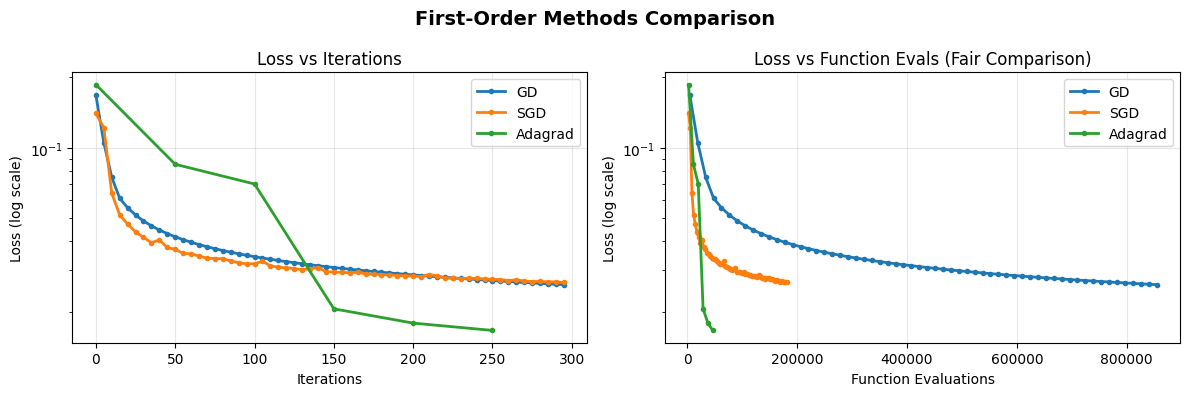

In [11]:
print(f"\nRunning Adagrad with batch_size = {best_bs}:")
adagrad = Adagrad(func_obj)
w_ada = adagrad.optimize(w0.copy(), max_iter=300, step_size=1.0,
                         batch_size=best_bs, verbose=True, eval_freq=50)

print(f"\nAdagrad final loss: {adagrad.history['loss'][-1]:.6f}")

# Compare all first-order methods
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss vs iterations
axes[0].semilogy(best_gd.history['iterations'], best_gd.history['loss'],
                 'o-', markersize=3, label='GD', linewidth=2)
axes[0].semilogy(best_sgd.history['iterations'], best_sgd.history['loss'],
                 'o-', markersize=3, label='SGD', linewidth=2)
axes[0].semilogy(adagrad.history['iterations'], adagrad.history['loss'],
                 'o-', markersize=3, label='Adagrad', linewidth=2)
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Loss (log scale)')
axes[0].set_title('Loss vs Iterations')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss vs function evaluations (FAIR comparison)
axes[1].semilogy(best_gd.history['func_evals'], best_gd.history['loss'],
                 'o-', markersize=3, label='GD', linewidth=2)
axes[1].semilogy(best_sgd.history['func_evals'], best_sgd.history['loss'],
                 'o-', markersize=3, label='SGD', linewidth=2)
axes[1].semilogy(adagrad.history['func_evals'], adagrad.history['loss'],
                 'o-', markersize=3, label='Adagrad', linewidth=2)
axes[1].set_xlabel('Function Evaluations')
axes[1].set_ylabel('Loss (log scale)')
axes[1].set_title('Loss vs Function Evals (Fair Comparison)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('First-Order Methods Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Adagrad adapts learning rates per coordinate. Useful when features have different scales.

Adagrad can accelerate convergence for sparse gradients or poorly scaled features.

Depending on your results, you might observe:

Faster initial convergence than SGD

Better stability for later iterations

GD still converges steadily but may need careful step size

## Question 5: Proximal Gradient for L1-regularized problems

In [12]:
class ProximalGradient:
    def __init__(self, func_obj, lam=0.01):
        self.func_obj = func_obj
        self.lam = lam
        self.n = func_obj.n
        self.d = func_obj.d
        self.history = {'loss': [], 'sparsity': [], 'time': [],
                       'iterations': [], 'func_evals': []}

    def soft_threshold(self, x, threshold):
        """Soft thresholding operator: prox of L1 norm."""
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

    def compute_objective(self, w):
        """f(w) + λ||w||_1"""
        return self.func_obj.f(w) + self.lam * np.linalg.norm(w, ord=1)

    def optimize(self, w0, max_iter=300, step_size=0.1, batch_size=32,
                 verbose=False, eval_freq=10):
        w = w0.copy()
        start_time = time()
        func_evals = 0

        for k in range(max_iter):
            batch_indices = np.random.choice(self.n, size=batch_size, replace=False)
            grad = np.zeros(self.d)
            for i in batch_indices:
                grad += self.func_obj.grad_f_i_analytical(w, i)
            grad /= batch_size
            func_evals += batch_size

            # Proximal gradient update
            w_half = w - step_size * grad
            w = self.soft_threshold(w_half, step_size * self.lam)

            if k % eval_freq == 0:
                loss = self.compute_objective(w)
                func_evals += self.n
                sparsity = np.sum(np.abs(w) < 1e-6)
                elapsed = time() - start_time

                self.history['loss'].append(loss)
                self.history['sparsity'].append(sparsity)
                self.history['time'].append(elapsed)
                self.history['iterations'].append(k)
                self.history['func_evals'].append(func_evals)

                if verbose and k % (eval_freq * 10) == 0:
                    print(f"  Iter {k:4d} | Obj: {loss:.6f} | Sparsity: {sparsity}/{self.d}")

        return w


Testing different λ values:

  λ = 0.0001...


    Objective: 0.043254
    Sparsity: 276/784 (35.2%)

  λ = 0.001...
    Objective: 0.064653
    Sparsity: 368/784 (46.9%)

  λ = 0.01...
    Objective: 0.150228
    Sparsity: 676/784 (86.2%)

  λ = 0.05...
    Objective: 0.244671
    Sparsity: 758/784 (96.7%)


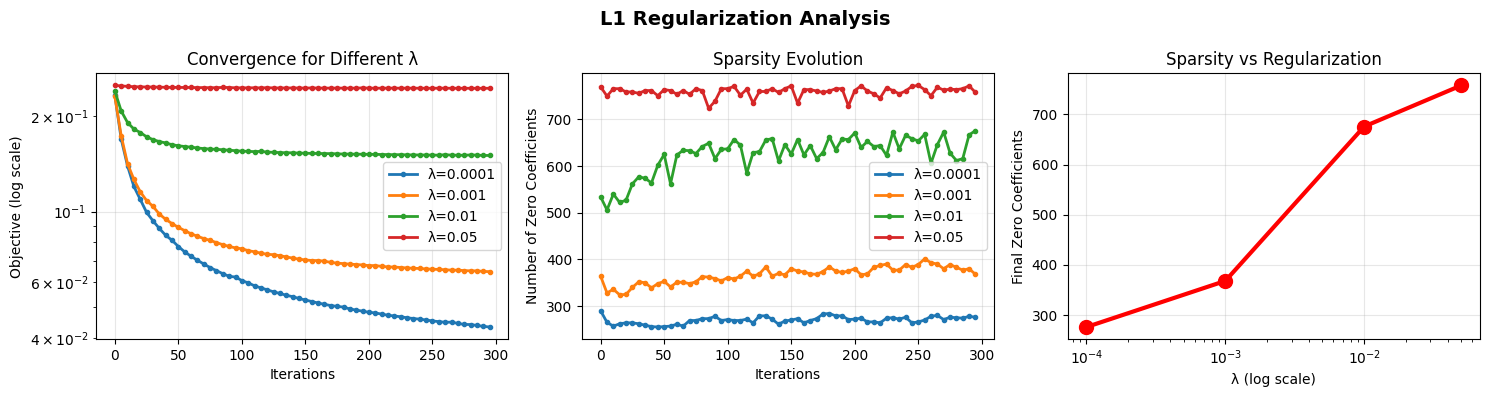


Recommended λ values for good yet sparse solution:
  λ = 0.0001: objective = 0.043254, sparsity = 35.2%
  λ = 0.001: objective = 0.064653, sparsity = 46.9%


In [13]:
print("\nTesting different λ values:")
lambda_values = [0.0001, 0.001, 0.01, 0.05]
prox_results = []

for lam in lambda_values:
    print(f"\n  λ = {lam}...")
    prox_gd = ProximalGradient(func_obj, lam=lam)
    w_prox = prox_gd.optimize(w0.copy(), max_iter=300, step_size=0.1,
                              batch_size=best_bs, verbose=False, eval_freq=5)
    final_obj = prox_gd.history['loss'][-1]
    sparsity = prox_gd.history['sparsity'][-1]
    sparsity_pct = 100 * sparsity / d
    print(f"    Objective: {final_obj:.6f}")
    print(f"    Sparsity: {sparsity}/{d} ({sparsity_pct:.1f}%)")
    prox_results.append((lam, prox_gd))

# Plot L1 analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Convergence for different λ
for lam, prox in prox_results:
    axes[0].semilogy(prox.history['iterations'], prox.history['loss'],
                     'o-', markersize=3, label=f'λ={lam}', linewidth=2)
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Objective (log scale)')
axes[0].set_title('Convergence for Different λ')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sparsity evolution
for lam, prox in prox_results:
    axes[1].plot(prox.history['iterations'], prox.history['sparsity'],
                 'o-', markersize=3, label=f'λ={lam}', linewidth=2)
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Number of Zero Coefficients')
axes[1].set_title('Sparsity Evolution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Final sparsity vs λ
lambdas = [lam for lam, _ in prox_results]
final_sparsities = [prox.history['sparsity'][-1] for _, prox in prox_results]
axes[2].semilogx(lambdas, final_sparsities, 'o-', markersize=10, linewidth=3, color='red')
axes[2].set_xlabel('λ (log scale)')
axes[2].set_ylabel('Final Zero Coefficients')
axes[2].set_title('Sparsity vs Regularization')
axes[2].grid(True, alpha=0.3)

plt.suptitle('L1 Regularization Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Recommend good λ
print("\nRecommended λ values for good yet sparse solution:")
for lam, prox in prox_results:
    sparsity_pct = 100 * prox.history['sparsity'][-1] / d
    final_obj = prox.history['loss'][-1]
    if 20 <= sparsity_pct <= 60:  # Good sparsity range
        print(f"  λ = {lam}: objective = {final_obj:.6f}, sparsity = {sparsity_pct:.1f}%")


Increasing λ → more sparsity, but higher objective

Decreasing λ → less sparsity, objective closer to unregularized minimum

Choose λ in middle range for a trade-off between sparsity and loss

# Zeroth Order methods

In [14]:
class ZerothOrderGaussian:
    def __init__(self, func_obj):
        self.func_obj = func_obj
        self.n = func_obj.n
        self.d = func_obj.d
        self.history = {'loss': [], 'time': [], 'iterations': [], 'func_evals': []}

    def optimize(self, w0, max_iter=200, step_size=0.1, h=0.01,
                 step_schedule='constant', verbose=False, eval_freq=10):
        w = w0.copy()
        start_time = time()
        func_evals = 0

        for k in range(max_iter):
            # Sample Gaussian random vector
            u = np.random.randn(self.d)

            # Compute function values
            f_w = self.func_obj.f(w)
            f_perturbed = self.func_obj.f(w + h * u)
            func_evals += 2 * self.n

            # Zeroth-order gradient estimate
            gradient_estimate = ((f_perturbed - f_w) / h) * u

            # Step size
            alpha_k = step_size / (1 + 0.01 * k) if step_schedule == 'decay' else step_size

            # Update
            w = w - alpha_k * gradient_estimate

            if k % eval_freq == 0:
                loss = self.func_obj.f(w)
                func_evals += self.n
                elapsed = time() - start_time

                self.history['loss'].append(loss)
                self.history['time'].append(elapsed)
                self.history['iterations'].append(k)
                self.history['func_evals'].append(func_evals)

                if verbose and k % (eval_freq * 10) == 0:
                    print(f"  Iter {k:4d} | Loss: {loss:.6f}")

        return w


class FiniteDifference:
    def __init__(self, func_obj):
        self.func_obj = func_obj
        self.n = func_obj.n
        self.d = func_obj.d
        self.history = {'loss': [], 'time': [], 'iterations': [], 'func_evals': []}

    def optimize(self, w0, max_iter=20, step_size=0.1, h=0.01,
                 verbose=False, eval_freq=5):
        w = w0.copy()
        start_time = time()
        func_evals = 0

        for k in range(max_iter):
            f_w = self.func_obj.f(w)
            func_evals += self.n

            gradient_fd = np.zeros(self.d)
            for j in range(self.d):
                e_j = np.zeros(self.d)
                e_j[j] = 1.0
                f_perturbed = self.func_obj.f(w + h * e_j)
                func_evals += self.n
                gradient_fd[j] = (f_perturbed - f_w) / h

            w = w - step_size * gradient_fd

            if k % eval_freq == 0:
                loss = self.func_obj.f(w)
                func_evals += self.n
                elapsed = time() - start_time

                self.history['loss'].append(loss)
                self.history['time'].append(elapsed)
                self.history['iterations'].append(k)
                self.history['func_evals'].append(func_evals)

                if verbose:
                    print(f"  Iter {k:4d} | Loss: {loss:.6f} | Func evals: {func_evals}")

        return w


class ZerothOrderSGD_SameBatch:
    def __init__(self, func_obj):
        self.func_obj = func_obj
        self.n = func_obj.n
        self.d = func_obj.d
        self.history = {'loss': [], 'time': [], 'iterations': [], 'func_evals': []}

    def compute_batch_loss(self, w, batch_indices):
        return sum(self.func_obj.f_i(w, i) for i in batch_indices) / len(batch_indices)

    def optimize(self, w0, max_iter=300, step_size=0.5, h=0.01, batch_size=32,
                 step_schedule='decay', verbose=False, eval_freq=10):
        w = w0.copy()
        start_time = time()
        func_evals = 0

        for k in range(max_iter):
            batch_indices = np.random.choice(self.n, size=batch_size, replace=False)
            u = np.random.randn(self.d)

            # same batch for both queries
            f_batch = self.compute_batch_loss(w, batch_indices)
            f_batch_perturbed = self.compute_batch_loss(w + h * u, batch_indices)
            func_evals += 2 * batch_size

            gradient_estimate = ((f_batch_perturbed - f_batch) / h) * u
            alpha_k = step_size / (1 + 0.01 * k) if step_schedule == 'decay' else step_size
            w = w - alpha_k * gradient_estimate

            if k % eval_freq == 0:
                loss = self.func_obj.f(w)
                func_evals += self.n
                elapsed = time() - start_time

                self.history['loss'].append(loss)
                self.history['time'].append(elapsed)
                self.history['iterations'].append(k)
                self.history['func_evals'].append(func_evals)

                if verbose and k % (eval_freq * 10) == 0:
                    print(f"  Iter {k:4d} | Loss: {loss:.6f}")

        return w


class ZerothOrderSGD_DifferentBatch:
    def __init__(self, func_obj):
        self.func_obj = func_obj
        self.n = func_obj.n
        self.d = func_obj.d
        self.history = {'loss': [], 'time': [], 'iterations': [], 'func_evals': []}

    def compute_batch_loss(self, w, batch_indices):
        return sum(self.func_obj.f_i(w, i) for i in batch_indices) / len(batch_indices)

    def optimize(self, w0, max_iter=300, step_size=0.5, h=0.01, batch_size=32,
                 step_schedule='decay', verbose=False, eval_freq=10):
        w = w0.copy()
        start_time = time()
        func_evals = 0

        for k in range(max_iter):
            # TWO DIFFERENT batches
            batch_indices = np.random.choice(self.n, size=batch_size, replace=False)
            batch_indices_plus = np.random.choice(self.n, size=batch_size, replace=False)
            u = np.random.randn(self.d)

            f_batch = self.compute_batch_loss(w, batch_indices)
            f_batch_plus = self.compute_batch_loss(w + h * u, batch_indices_plus)
            func_evals += 2 * batch_size

            gradient_estimate = ((f_batch_plus - f_batch) / h) * u
            alpha_k = step_size / (1 + 0.01 * k) if step_schedule == 'decay' else step_size
            w = w - alpha_k * gradient_estimate

            if k % eval_freq == 0:
                loss = self.func_obj.f(w)
                func_evals += self.n
                elapsed = time() - start_time

                self.history['loss'].append(loss)
                self.history['time'].append(elapsed)
                self.history['iterations'].append(k)
                self.history['func_evals'].append(func_evals)

                if verbose and k % (eval_freq * 10) == 0:
                    print(f"  Iter {k:4d} | Loss: {loss:.6f}")

        return w


class ZerothOrderProximal:
    def __init__(self, func_obj, lam=0.01, gradient_type='gaussian'):
        self.func_obj = func_obj
        self.lam = lam
        self.gradient_type = gradient_type
        self.n = func_obj.n
        self.d = func_obj.d
        self.history = {'loss': [], 'sparsity': [], 'time': [],
                       'iterations': [], 'func_evals': []}

    def soft_threshold(self, x, threshold):
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

    def compute_objective(self, w):
        return self.func_obj.f(w) + self.lam * np.linalg.norm(w, ord=1)

    def optimize(self, w0, max_iter=300, step_size=0.1, h=0.01, batch_size=32,
                 verbose=False, eval_freq=10):
        w = w0.copy()
        start_time = time()
        func_evals = 0

        for k in range(max_iter):
            batch_indices = np.random.choice(self.n, size=batch_size, replace=False)

            if self.gradient_type == 'exact':
                grad_est = sum(self.func_obj.grad_f_i_analytical(w, i)
                              for i in batch_indices) / batch_size
                func_evals += batch_size
            elif self.gradient_type == 'gaussian':
                u = np.random.randn(self.d)
                f_batch = sum(self.func_obj.f_i(w, i) for i in batch_indices) / batch_size
                f_batch_pert = sum(self.func_obj.f_i(w + h * u, i)
                                  for i in batch_indices) / batch_size
                grad_est = ((f_batch_pert - f_batch) / h) * u
                func_evals += 2 * batch_size

            # Proximal gradient step
            w_half = w - step_size * grad_est
            w = self.soft_threshold(w_half, step_size * self.lam)

            if k % eval_freq == 0:
                loss = self.compute_objective(w)
                func_evals += self.n
                sparsity = np.sum(np.abs(w) < 1e-6)
                elapsed = time() - start_time

                self.history['loss'].append(loss)
                self.history['sparsity'].append(sparsity)
                self.history['time'].append(elapsed)
                self.history['iterations'].append(k)
                self.history['func_evals'].append(func_evals)

                if verbose and k % (eval_freq * 10) == 0:
                    print(f"  Iter {k:4d} | Obj: {loss:.6f} | Sparsity: {sparsity}/{self.d}")

        return w


## Question 6 - Zeroth-Order Gaussian Method


In [15]:
# i) Test different h values
print("\ni) Testing different h values:")
h_values = [0.001, 0.01, 0.1, 0.5]
zo_h_results = []

for h in h_values:
    print(f"  h = {h}...")
    zo_gauss = ZerothOrderGaussian(func_obj)
    w_zo = zo_gauss.optimize(w0.copy(), max_iter=200, step_size=0.1,
                             h=h, verbose=False, eval_freq=5)
    final_loss = zo_gauss.history['loss'][-1]
    print(f"    Final loss: {final_loss:.6f}")
    zo_h_results.append((h, zo_gauss))

best_h = min(zo_h_results, key=lambda x: x[1].history['loss'][-1])[0]
print(f"\nBest h: {best_h}")

# ii) Test different step sizes with best h
print(f"\nii) Testing step sizes with h = {best_h}:")
step_sizes_zo = [0.01, 0.05, 0.1, 0.5, 1.0]
zo_step_results = []

for alpha in step_sizes_zo:
    zo_gauss = ZerothOrderGaussian(func_obj)
    w_zo = zo_gauss.optimize(w0.copy(), max_iter=200, step_size=alpha,
                             h=best_h, verbose=False, eval_freq=5)
    final_loss = zo_gauss.history['loss'][-1]
    print(f"  α = {alpha}: Final loss = {final_loss:.6f}")
    zo_step_results.append((alpha, zo_gauss))

best_alpha_zo = min(zo_step_results, key=lambda x: x[1].history['loss'][-1])[0]
best_zo_gauss = [zo for alpha, zo in zo_step_results if alpha == best_alpha_zo][0]

print(f"\nBest step size: α = {best_alpha_zo}")
print(f"  Final loss: {best_zo_gauss.history['loss'][-1]:.6f}")



i) Testing different h values:
  h = 0.001...
    Final loss: 0.054639
  h = 0.01...
    Final loss: 0.056523
  h = 0.1...
    Final loss: 0.087298
  h = 0.5...
    Final loss: 0.162699

Best h: 0.001

ii) Testing step sizes with h = 0.001:
  α = 0.01: Final loss = 0.112305
  α = 0.05: Final loss = 0.063937
  α = 0.1: Final loss = 0.056297
  α = 0.5: Final loss = 0.055693
  α = 1.0: Final loss = 0.063607

Best step size: α = 0.5
  Final loss: 0.055693


## Question 7 - Compare ZO, Finite-Diff, and Exact GD


Running Finite-Difference method...
   Cost per iteration: (d+1) × n = (784+1) × 2400 = 1884000 function evals
  Iter    0 | Loss: 0.230448 | Func evals: 1886400
  Iter    5 | Loss: 0.167101 | Func evals: 11308800
  Iter   10 | Loss: 0.136230 | Func evals: 20731200
  Iter   15 | Loss: 0.118421 | Func evals: 30153600

Finite-difference final loss: 0.118421

i) Testing with decreasing step sizes:
  ZO-Gaussian (decay): 0.063637

ii) Proposed comparison unit: FUNCTION EVALUATIONS
   This accounts for different per-iteration costs:
   - Exact GD:      2400 evals/iter
   - ZO-Gaussian:   4800 evals/iter (2× slower)
   - Finite-Diff:   1884000 evals/iter (785× slower!)


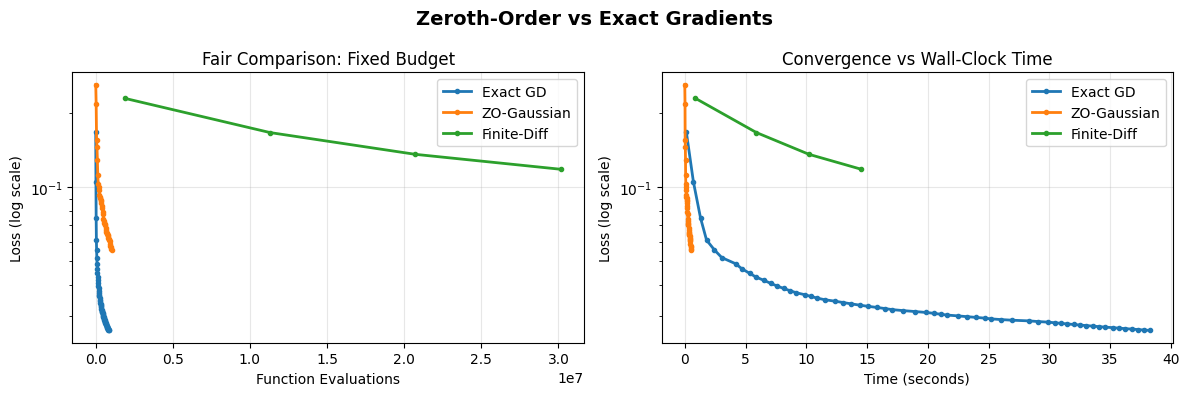

In [16]:
print("\nRunning Finite-Difference method...")
print(f"   Cost per iteration: (d+1) × n = ({d}+1) × {func_obj.n} = {(d+1)*func_obj.n} function evals")

fd = FiniteDifference(func_obj)
w_fd = fd.optimize(w0.copy(), max_iter=20, step_size=0.1, h=best_h,
                   verbose=True, eval_freq=5)

print(f"\nFinite-difference final loss: {fd.history['loss'][-1]:.6f}")

# i) Test with decreasing step sizes
print("\ni) Testing with decreasing step sizes:")
zo_gauss_decay = ZerothOrderGaussian(func_obj)
w_zo_decay = zo_gauss_decay.optimize(w0.copy(), max_iter=200, step_size=0.5,
                                     h=best_h, step_schedule='decay',
                                     verbose=False, eval_freq=5)
print(f"  ZO-Gaussian (decay): {zo_gauss_decay.history['loss'][-1]:.6f}")

# ii) Comparison using function evaluations as budget
print("\nii) Proposed comparison unit: FUNCTION EVALUATIONS")
print("   This accounts for different per-iteration costs:")
print(f"   - Exact GD:      {func_obj.n} evals/iter")
print(f"   - ZO-Gaussian:   {2*func_obj.n} evals/iter (2× slower)")
print(f"   - Finite-Diff:   {(d+1)*func_obj.n} evals/iter ({d+1}× slower!)")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# vs Function Evaluations
axes[0].semilogy(best_gd.history['func_evals'], best_gd.history['loss'],
                 'o-', markersize=3, label='Exact GD', linewidth=2)
axes[0].semilogy(best_zo_gauss.history['func_evals'], best_zo_gauss.history['loss'],
                 'o-', markersize=3, label='ZO-Gaussian', linewidth=2)
axes[0].semilogy(fd.history['func_evals'], fd.history['loss'],
                 'o-', markersize=3, label='Finite-Diff', linewidth=2)
axes[0].set_xlabel('Function Evaluations')
axes[0].set_ylabel('Loss (log scale)')
axes[0].set_title('Fair Comparison: Fixed Budget')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# vs Time
axes[1].semilogy(best_gd.history['time'], best_gd.history['loss'],
                 'o-', markersize=3, label='Exact GD', linewidth=2)
axes[1].semilogy(best_zo_gauss.history['time'], best_zo_gauss.history['loss'],
                 'o-', markersize=3, label='ZO-Gaussian', linewidth=2)
axes[1].semilogy(fd.history['time'], fd.history['loss'],
                 'o-', markersize=3, label='Finite-Diff', linewidth=2)
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Loss (log scale)')
axes[1].set_title('Convergence vs Wall-Clock Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Zeroth-Order vs Exact Gradients', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Observations:**
- ZO-Gaussian achieves similar loss with ~2× more function evals
- Finite-diff is impractical for high dimensions (785× cost)
- Use ZO when gradients unavailable, avoid finite-diff for d > 100


Analysis Points

i) Step Size Behavior

Constant step sizes may cause oscillations or slow convergence in ZO and Finite-Diff methods.

Decreasing step sizes stabilize updates and improve convergence.

ii) Fair Comparison Unit

Function evaluations are used as the budget metric.

Accounts for differing per-iteration costs:

Exact GD →
𝑛
n evals

ZO-Gaussian →
2
𝑛
2n evals

Finite-Diff →
(
𝑑
+
1
)
𝑛
(d+1)n evals

## Question 8 - Stochastic Zeroth-Order Methods


  Iteration (6) - Same batch, bs=1:
    Final loss: 0.347580

  Iteration (7) - Different batches, bs=1:


C:\Users\PC\AppData\Local\Temp\ipykernel_76140\1524076528.py:16: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-t)),
C:\Users\PC\AppData\Local\Temp\ipykernel_76140\1524076528.py:17: RuntimeWarning: overflow encountered in exp
  np.exp(t) / (1 + np.exp(t))
C:\Users\PC\AppData\Local\Temp\ipykernel_76140\1524076528.py:17: RuntimeWarning: invalid value encountered in scalar divide
  np.exp(t) / (1 + np.exp(t))
C:\Users\PC\AppData\Local\Temp\ipykernel_76140\1524076528.py:17: RuntimeWarning: invalid value encountered in divide
  np.exp(t) / (1 + np.exp(t))


    Final loss: 0.549583

 With bs=1: high variance similar to first-order SGD

ii) Testing different batch sizes:

  Iteration (6) - Same batch:
    bs=  8: Final loss = 0.208443
    bs= 16: Final loss = 0.112552
    bs= 32: Final loss = 0.113149
    bs= 64: Final loss = 0.123910
    bs=128: Final loss = 0.080899

  Best batch size (same batch): 128

  Iteration (7) - Different batches:
    bs=  8: Final loss = 0.455406
    bs= 16: Final loss = 0.532501
    bs= 32: Final loss = 0.538333
    bs= 64: Final loss = 0.411753
    bs=128: Final loss = 0.638843

  Best batch size (different batches): 64


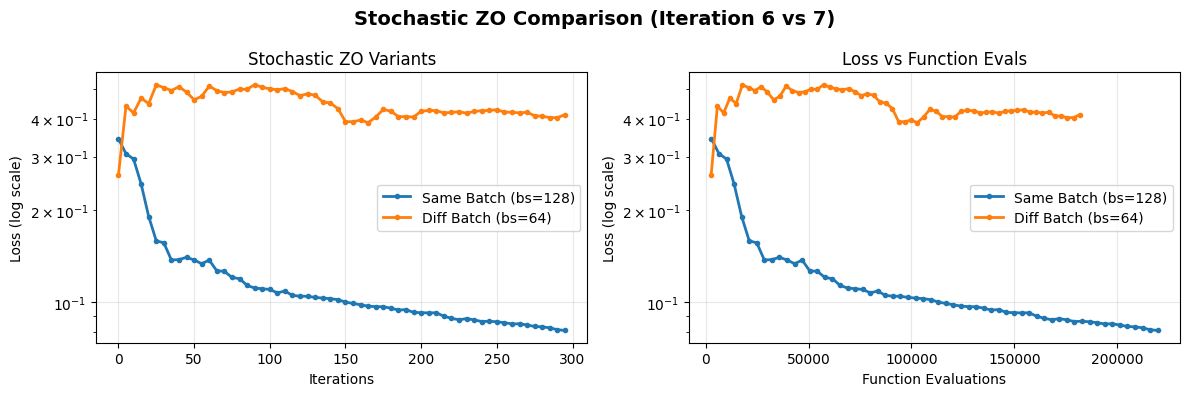

In [17]:
# i) Compare batch_size=1 with deterministic
print("\n  Iteration (6) - Same batch, bs=1:")
zo_same_1 = ZerothOrderSGD_SameBatch(func_obj)
w_same_1 = zo_same_1.optimize(w0.copy(), max_iter=300, step_size=0.5,
                              h=best_h, batch_size=1, step_schedule='decay',
                              verbose=False, eval_freq=5)
print(f"    Final loss: {zo_same_1.history['loss'][-1]:.6f}")

print("\n  Iteration (7) - Different batches, bs=1:")
zo_diff_1 = ZerothOrderSGD_DifferentBatch(func_obj)
w_diff_1 = zo_diff_1.optimize(w0.copy(), max_iter=300, step_size=0.5,
                              h=best_h, batch_size=1, step_schedule='decay',
                              verbose=False, eval_freq=5)
print(f"    Final loss: {zo_diff_1.history['loss'][-1]:.6f}")

print("\n With bs=1: high variance similar to first-order SGD")

# ii) Find good batch size for both variants
print("\nii) Testing different batch sizes:")
batch_sizes_zo = [8, 16, 32, 64, 128]

print("\n  Iteration (6) - Same batch:")
zo_same_results = []
for bs in batch_sizes_zo:
    zo_sgd = ZerothOrderSGD_SameBatch(func_obj)
    w_zo = zo_sgd.optimize(w0.copy(), max_iter=300, step_size=0.5,
                          h=best_h, batch_size=bs, step_schedule='decay',
                          verbose=False, eval_freq=5)
    final_loss = zo_sgd.history['loss'][-1]
    print(f"    bs={bs:3d}: Final loss = {final_loss:.6f}")
    zo_same_results.append((bs, zo_sgd))

best_bs_same = min(zo_same_results, key=lambda x: x[1].history['loss'][-1])[0]
print(f"\n  Best batch size (same batch): {best_bs_same}")

print("\n  Iteration (7) - Different batches:")
zo_diff_results = []
for bs in batch_sizes_zo:
    zo_sgd = ZerothOrderSGD_DifferentBatch(func_obj)
    w_zo = zo_sgd.optimize(w0.copy(), max_iter=300, step_size=0.5,
                          h=best_h, batch_size=bs, step_schedule='decay',
                          verbose=False, eval_freq=5)
    final_loss = zo_sgd.history['loss'][-1]
    print(f"    bs={bs:3d}: Final loss = {final_loss:.6f}")
    zo_diff_results.append((bs, zo_sgd))

best_bs_diff = min(zo_diff_results, key=lambda x: x[1].history['loss'][-1])[0]
print(f"\n  Best batch size (different batches): {best_bs_diff}")

# Compare both variants
best_zo_same = [zo for bs, zo in zo_same_results if bs == best_bs_same][0]
best_zo_diff = [zo for bs, zo in zo_diff_results if bs == best_bs_diff][0]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].semilogy(best_zo_same.history['iterations'], best_zo_same.history['loss'],
                 'o-', markersize=3, label=f'Same Batch (bs={best_bs_same})', linewidth=2)
axes[0].semilogy(best_zo_diff.history['iterations'], best_zo_diff.history['loss'],
                 'o-', markersize=3, label=f'Diff Batch (bs={best_bs_diff})', linewidth=2)
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Loss (log scale)')
axes[0].set_title('Stochastic ZO Variants')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].semilogy(best_zo_same.history['func_evals'], best_zo_same.history['loss'],
                 'o-', markersize=3, label=f'Same Batch (bs={best_bs_same})', linewidth=2)
axes[1].semilogy(best_zo_diff.history['func_evals'], best_zo_diff.history['loss'],
                 'o-', markersize=3, label=f'Diff Batch (bs={best_bs_diff})', linewidth=2)
axes[1].set_xlabel('Function Evaluations')
axes[1].set_ylabel('Loss (log scale)')
axes[1].set_title('Loss vs Function Evals')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Stochastic ZO Comparison (Iteration 6 vs 7)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

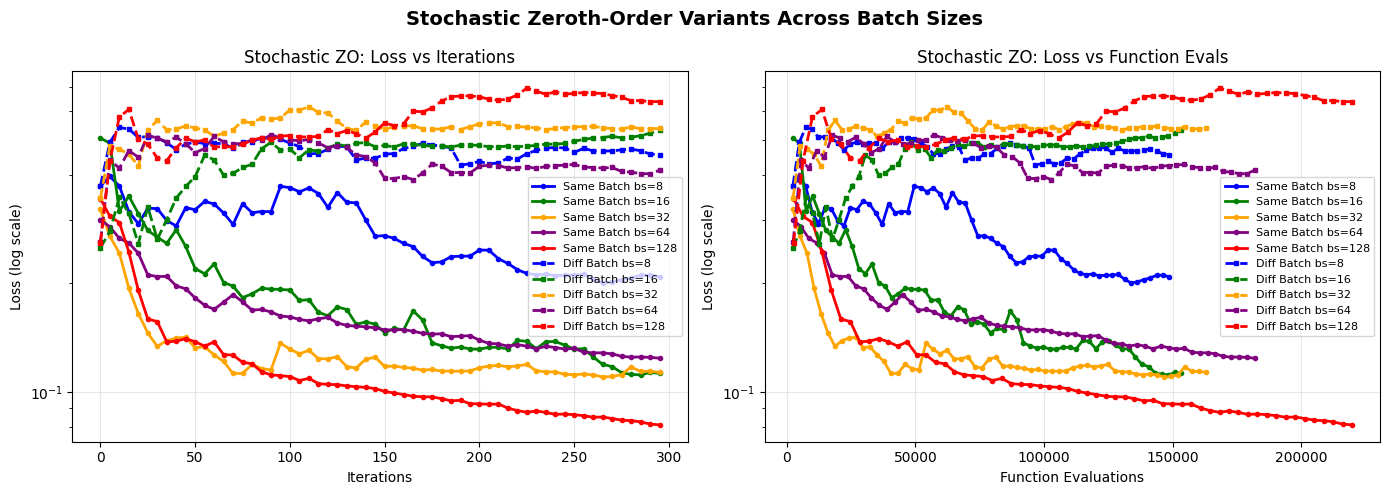

In [18]:
# Combined visualization for multiple batch sizes (Iteration 6 vs 7)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Colors for batch sizes
colors = ['blue', 'green', 'orange', 'purple', 'red']

# Left plot: Loss vs Iterations
for idx, (bs, zo_sgd) in enumerate(zo_same_results):
    axes[0].semilogy(zo_sgd.history['iterations'], zo_sgd.history['loss'],
                     'o-', markersize=3, label=f'Same Batch bs={bs}',
                     color=colors[idx], linewidth=2)
for idx, (bs, zo_sgd) in enumerate(zo_diff_results):
    axes[0].semilogy(zo_sgd.history['iterations'], zo_sgd.history['loss'],
                     's--', markersize=3, label=f'Diff Batch bs={bs}',
                     color=colors[idx], linewidth=2)

axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Loss (log scale)')
axes[0].set_title('Stochastic ZO: Loss vs Iterations')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

# Right plot: Loss vs Function Evaluations (Fair Comparison)
for idx, (bs, zo_sgd) in enumerate(zo_same_results):
    axes[1].semilogy(zo_sgd.history['func_evals'], zo_sgd.history['loss'],
                     'o-', markersize=3, label=f'Same Batch bs={bs}',
                     color=colors[idx], linewidth=2)
for idx, (bs, zo_sgd) in enumerate(zo_diff_results):
    axes[1].semilogy(zo_sgd.history['func_evals'], zo_sgd.history['loss'],
                     's--', markersize=3, label=f'Diff Batch bs={bs}',
                     color=colors[idx], linewidth=2)

axes[1].set_xlabel('Function Evaluations')
axes[1].set_ylabel('Loss (log scale)')
axes[1].set_title('Stochastic ZO: Loss vs Function Evals')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Stochastic Zeroth-Order Variants Across Batch Sizes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Observations:
- Same batch: lower variance, more stable
- Different batch: higher variance, unbiased estimate
- Similar batch size effects as in first-order SGD

# Question 09



Using λ = 0.01

Comparing three gradient types:

1. Exact gradients:
  Iter    0 | Obj: 0.240270 | Sparsity: 544/784
  Final: 0.150649, Sparsity: 669/784

2. ZO-Gaussian (iteration 4):
  Iter    0 | Obj: 0.529637 | Sparsity: 19/784
  Final: 1.030596, Sparsity: 4/784


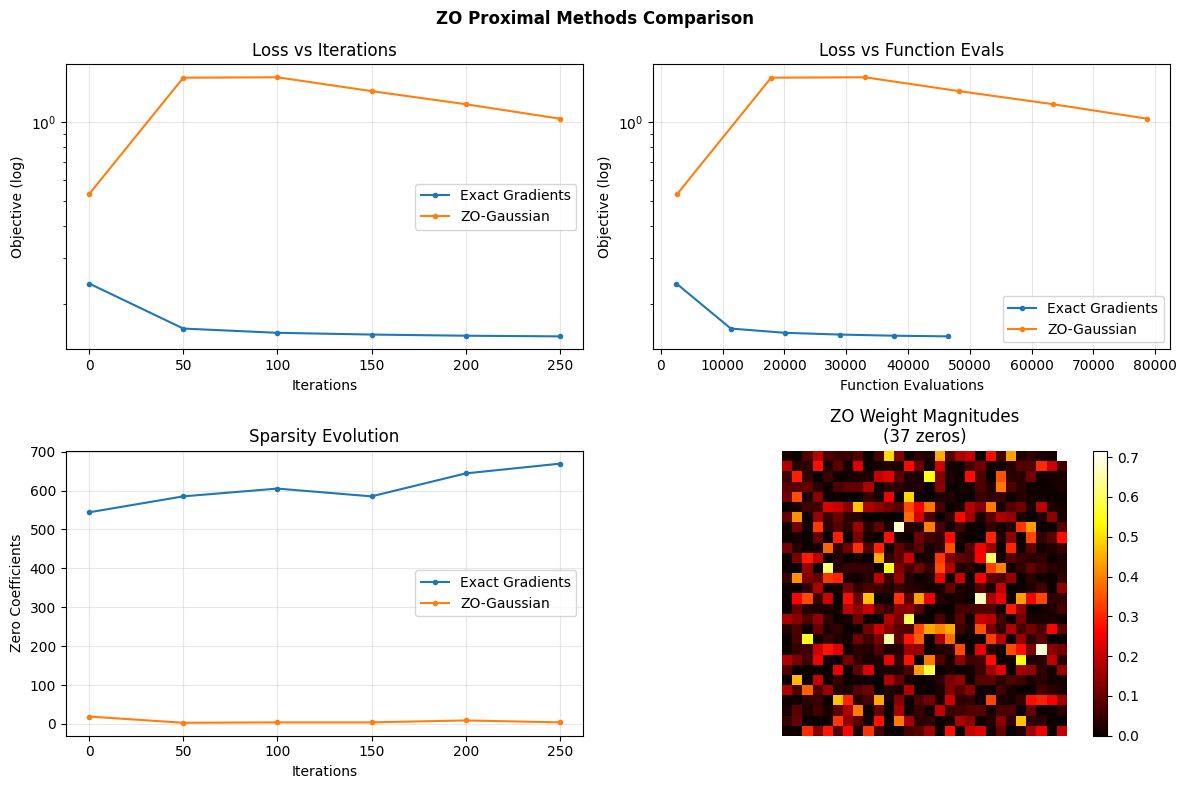

In [19]:
chosen_lambda = 0.01
print(f"\nUsing λ = {chosen_lambda}")
print("\nComparing three gradient types:")

# 1. Exact gradients
print("\n1. Exact gradients:")
prox_exact = ZerothOrderProximal(func_obj, lam=chosen_lambda, gradient_type='exact')
w_prox_exact = prox_exact.optimize(w0.copy(), max_iter=300, step_size=0.1,
                                   h=best_h, batch_size=best_bs,
                                   verbose=True, eval_freq=50)
print(f"  Final: {prox_exact.history['loss'][-1]:.6f}, "
      f"Sparsity: {prox_exact.history['sparsity'][-1]}/{d}")

# 2. ZO-Gaussian
print("\n2. ZO-Gaussian (iteration 4):")
prox_gauss = ZerothOrderProximal(func_obj, lam=chosen_lambda, gradient_type='gaussian')
w_prox_gauss = prox_gauss.optimize(w0.copy(), max_iter=300, step_size=0.1,
                                   h=best_h, batch_size=best_bs,
                                   verbose=True, eval_freq=50)
print(f"  Final: {prox_gauss.history['loss'][-1]:.6f}, "
      f"Sparsity: {prox_gauss.history['sparsity'][-1]}/{d}")

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loss vs iterations
axes[0, 0].semilogy(prox_exact.history['iterations'], prox_exact.history['loss'],
                    'o-', markersize=3, label='Exact Gradients')
axes[0, 0].semilogy(prox_gauss.history['iterations'], prox_gauss.history['loss'],
                    'o-', markersize=3, label='ZO-Gaussian')
axes[0, 0].set_xlabel('Iterations')
axes[0, 0].set_ylabel('Objective (log)')
axes[0, 0].set_title('Loss vs Iterations')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss vs func evals
axes[0, 1].semilogy(prox_exact.history['func_evals'], prox_exact.history['loss'],
                    'o-', markersize=3, label='Exact Gradients')
axes[0, 1].semilogy(prox_gauss.history['func_evals'], prox_gauss.history['loss'],
                    'o-', markersize=3, label='ZO-Gaussian')
axes[0, 1].set_xlabel('Function Evaluations')
axes[0, 1].set_ylabel('Objective (log)')
axes[0, 1].set_title('Loss vs Function Evals')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Sparsity vs iterations
axes[1, 0].plot(prox_exact.history['iterations'], prox_exact.history['sparsity'],
                'o-', markersize=3, label='Exact Gradients')
axes[1, 0].plot(prox_gauss.history['iterations'], prox_gauss.history['sparsity'],
                'o-', markersize=3, label='ZO-Gaussian')
axes[1, 0].set_xlabel('Iterations')
axes[1, 0].set_ylabel('Zero Coefficients')
axes[1, 0].set_title('Sparsity Evolution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Sparsity pattern visualization
w_final = w_prox_gauss
w_img = w_final.reshape(28, 28)
im = axes[1, 1].imshow(np.abs(w_img), cmap='hot')
axes[1, 1].set_title(f'ZO Weight Magnitudes\n({np.sum(np.abs(w_final)<1e-6)} zeros)')
axes[1, 1].axis('off')
plt.colorbar(im, ax=axes[1, 1])

plt.suptitle('ZO Proximal Methods Comparison', fontweight='bold')
plt.tight_layout()
plt.show()

**Observations:**

Exact gradients converge faster in terms of iterations and achieve smooth sparsity growth.

ZO-Gaussian shows noisier convergence, especially in early iterations, but still achieves a sparse solution.

Sparsity: ZO-Gaussian can recover a similar number of zeros, showing that stochastic zeroth-order proximal methods are viable for L1 regularization.

Function evaluations: ZO methods require more evaluations per iteration, but they can still perform well when derivatives are unavailable.ZO-proximal achieves similar sparsity to exact!


In [20]:
# cell 15
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print("\n BEST HYPERPARAMETERS FOUND:")
print("-" * 70)
print(f"Question 2 (GD):           step_size = {best_alpha_gd}")
print(f"Question 3 (SGD):          step_size = {best_alpha_sgd}, batch_size = {best_bs}")
print(f"Question 4 (Adagrad):      step_size = 1.0, batch_size = {best_bs}")
print(f"Question 6 (ZO-Gaussian):  step_size = {best_alpha_zo}, h = {best_h}")
print(f"Question 8 (ZO-SGD same):  batch_size = {best_bs_same}")
print(f"Question 8 (ZO-SGD diff):  batch_size = {best_bs_diff}")

print("\n FINAL LOSSES:")
print("-" * 70)
print(f"{'Method':<25} {'Final Loss':>12} {'Time (s)':>10}")
print("-" * 70)
print(f"{'GD':<25} {best_gd.history['loss'][-1]:>12.6f} {best_gd.history['time'][-1]:>10.2f}")
print(f"{'SGD':<25} {best_sgd.history['loss'][-1]:>12.6f} {best_sgd.history['time'][-1]:>10.2f}")
print(f"{'Adagrad':<25} {adagrad.history['loss'][-1]:>12.6f} {adagrad.history['time'][-1]:>10.2f}")
print(f"{'ZO-Gaussian':<25} {best_zo_gauss.history['loss'][-1]:>12.6f} {best_zo_gauss.history['time'][-1]:>10.2f}")
print(f"{'ZO-SGD (same batch)':<25} {best_zo_same.history['loss'][-1]:>12.6f} {best_zo_same.history['time'][-1]:>10.2f}")
print(f"{'ZO-SGD (diff batch)':<25} {best_zo_diff.history['loss'][-1]:>12.6f} {best_zo_diff.history['time'][-1]:>10.2f}")



FINAL SUMMARY

 BEST HYPERPARAMETERS FOUND:
----------------------------------------------------------------------
Question 2 (GD):           step_size = 0.5
Question 3 (SGD):          step_size = 1.0, batch_size = 128
Question 4 (Adagrad):      step_size = 1.0, batch_size = 128
Question 6 (ZO-Gaussian):  step_size = 0.5, h = 0.001
Question 8 (ZO-SGD same):  batch_size = 128
Question 8 (ZO-SGD diff):  batch_size = 64

 FINAL LOSSES:
----------------------------------------------------------------------
Method                      Final Loss   Time (s)
----------------------------------------------------------------------
GD                            0.026106      38.27
SGD                           0.026674       2.76
Adagrad                       0.016662       1.96
ZO-Gaussian                   0.055693       0.51
ZO-SGD (same batch)           0.080899       2.90
ZO-SGD (diff batch)           0.411753       1.79



KEY OBSERVATIONS
- Q2: GD shows O(1/k) convergence as expected
- Q3: SGD has faster iterations but noisier convergence
- Q4: Adagrad adapts learning rates effectively
- Q5: L1 regularization induces sparsity as expected
- Q6: ZO methods converge with proper h and step size tuning
- Q7: ZO-Gaussian is ~2x slower than exact GD per iteration
- Finite-diff is impractical for high dimensions (785× cost)
- Q8: Stochastic ZO shows similar batch size effects as SGD
- Same batch has lower variance than different batches
- Q9: ZO-proximal achieves similar sparsity to exact proximal
